## LPA - Trabalho: Preço dos carros no Brasil
---

Objetivos do projeto:
1. Análise Descritiva – Explorar e visualizar os dados de preços médios de carros no Brasil em 2021, identificando padrões e tendências.

2. Predição – Construir e avaliar modelos de Machine Learning (Random Forest e XGBoost) para prever o preço dos carros com base em características selecionadas.


---

## Parte 1 - Importação das bibliotecas



In [113]:
import pandas as pd  # Biblioteca Pandas - Manipulação de dados
import seaborn as sns  # Biblioteca Seaborn - Criação de gráficos
import matplotlib.pyplot as plt  # Biblioteca Matplotlib - Criação de gráficos

# OPCIONAL - Biblioteca para ignorar mensagens de warning (aviso) ao rodar uma célula de código
import warnings
warnings.filterwarnings('ignore')

In [114]:
# Bibliotecas de machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder

# Métricas de avaliação dos modelos
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

---
## Parte 2 - Importação dos dados


###### 1a. Carregamento da base de dados

In [115]:
dados = pd.read_csv('/content/drive/MyDrive/00 - COLAB/2 - IAA-LPA/trabalho/precos_carros_brasil.csv')  # Função read_csv da biblioteca Pandas (pd) para importar os dados

Certificando-se de que os dados foram lidos corretamente ↓

In [116]:
dados.columns  # Colunas da tabela

Index(['year_of_reference', 'month_of_reference', 'fipe_code',
       'authentication', 'brand', 'model', 'fuel', 'gear', 'engine_size',
       'year_model', 'avg_price_brl'],
      dtype='object')

In [117]:
dados.head(2)  # Duas primeiras linhas

,year_of_reference,month_of_reference,fipe_code,authentication,brand,model,fuel,gear,engine_size,year_model,avg_price_brl
0,2021.0,January,004001-0,cfzlctzfwrcp,GM - Chevrolet,Corsa Wind 1.0 MPFI / EFI 2p,Gasoline,manual,1,2002.0,9162.0
1,2021.0,January,004001-0,cdqwxwpw3y2p,GM - Chevrolet,Corsa Wind 1.0 MPFI / EFI 2p,Gasoline,manual,1,2001.0,8832.0


In [118]:
dados.shape  # Qtd. de linhas vs qtd. de colunas

(267542, 11)

---
## Parte 3 - Análise dos dados

### 0 - Opcional: Tratamentos para facilitar a análise
Nesta subseção, as colunas são reordenadas para que a organização da tabela fiquei mais lógica. Essa etapa é completamente opcional. Além disso, um dicionário é criado para facilitar a consulta da descrição das colunas.

In [119]:
ordem_cols = ["model", "avg_price_brl", "brand", "fuel", "gear", "engine_size", "year_model", "fipe_code", "month_of_reference", "year_of_reference", "authentication"]

In [120]:
dados = dados[ordem_cols]

In [121]:
descricao_cols = {
    "model" : "Modelo do carro",
    "avg_price_brl" : "Preço médio do carro, em reais",
    "fipe_code" : "Código único da FIPE",
    "brand" : "Marca de carro",
    "fuel" : "Tipo de combustível do carro",
    "gear" : "Tipo de câmbio do carro",
    "engine_size" : "Tamanho do motor em centímetros cúbicos",  # creio que seja em decímetros cúbicos: um decímetro cúbico (dm³) equivale a 1 litro
    "year_model" : "Ano de modelo do carro. Pode não corresponder ao ano de fabricação",
    "month_of_reference" : "O preço médio corresponde",
    "year_of_reference" : "O preço médio corresponde a um mês de ano de referência",
    "authentication" : "Código de autenticação único para consulta no site da FIPE"
}

In [122]:
dados.head(1)

,model,avg_price_brl,brand,fuel,gear,engine_size,year_model,fipe_code,month_of_reference,year_of_reference,authentication
0,Corsa Wind 1.0 MPFI / EFI 2p,9162.0,GM - Chevrolet,Gasoline,manual,1,2002.0,004001-0,January,2021.0,cfzlctzfwrcp


### 1 - AED - Análise Exploratória dos Dados / EDA - Exploratory Data Analysis

###### Em um primeiro momento, iremos nos familiarizar com os dados e analisá-los com mais detalhes.

In [123]:
dados.head(2)

,model,avg_price_brl,brand,fuel,gear,engine_size,year_model,fipe_code,month_of_reference,year_of_reference,authentication
0,Corsa Wind 1.0 MPFI / EFI 2p,9162.0,GM - Chevrolet,Gasoline,manual,1,2002.0,004001-0,January,2021.0,cfzlctzfwrcp
1,Corsa Wind 1.0 MPFI / EFI 2p,8832.0,GM - Chevrolet,Gasoline,manual,1,2001.0,004001-0,January,2021.0,cdqwxwpw3y2p


In [124]:
dados.dtypes  # Imprime o tipo de dado em cada coluna: object - variáveis categóricas; float64 e int64 - variáveis numéricas

,0
model,object
avg_price_brl,float64
brand,object
fuel,object
gear,object
engine_size,object
year_model,float64
fipe_code,object
month_of_reference,object
year_of_reference,float64


###### 1b. Seguimos com a verificação de valores faltantes.

In [125]:
dados.isna().any()  # Há algum valor faltante nas colunas?

,0
model,True
avg_price_brl,True
brand,True
fuel,True
gear,True
engine_size,True
year_model,True
fipe_code,True
month_of_reference,True
year_of_reference,True


In [126]:
dados.isna().sum()  # Obtendo a *quantidade* de valores faltantes em cada coluna

,0
model,65245
avg_price_brl,65245
brand,65245
fuel,65245
gear,65245
engine_size,65245
year_model,65245
fipe_code,65245
month_of_reference,65245
year_of_reference,65245


In [127]:
dados[dados.isnull().any(axis=1)]  # Obtendo as linhas que possuem valores nulos

,model,avg_price_brl,brand,fuel,gear,engine_size,year_model,fipe_code,month_of_reference,year_of_reference,authentication
202297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
267537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Tendo observado acima ↑ que os valores nulos fazem parte de linhas completamente nulas, iremos removê-las.

In [128]:
dados.dropna(how="all", inplace=True)  # O parâmetro 'inplace' dita se a exclusão vai ser realizada na tabela original ou em uma 'cópia'

In [129]:
dados.isna().sum()  # Confirmando a exclusão

,0
model,0
avg_price_brl,0
brand,0
fuel,0
gear,0
engine_size,0
year_model,0
fipe_code,0
month_of_reference,0
year_of_reference,0


###### 1c. Agora, devemos analisar se os dados possuem linhas idênticas (valores duplicados).

In [130]:
dados.duplicated().any()  # Há algum valor duplicado nas linhas?

np.True_

In [131]:
dados.duplicated().sum()  # Quantas linhas estão duplicadas?

np.int64(2)

In [132]:
dados[dados.duplicated(keep=False)]  # O parâmetro 'keep' define se a função .duplicated mostrará a linha original e a linha duplicada ou se somente a linha duplicada.

,model,avg_price_brl,brand,fuel,gear,engine_size,year_model,fipe_code,month_of_reference,year_of_reference,authentication
45791,DUSTER OROCH Dyna. 2.0 Flex 16V Mec.,69893.0,Renault,Gasoline,manual,2,2018.0,025232-8,June,2021.0,5rtdwkpkpq5h
45793,DUSTER OROCH Dyna. 2.0 Flex 16V Mec.,69893.0,Renault,Gasoline,manual,2,2018.0,025232-8,June,2021.0,5rtdwkpkpq5h
189895,Ranger Limited 3.0 PSE 4x4 CD TB Diesel,64638.0,Ford,Diesel,manual,3,2007.0,003296-4,December,2022.0,3r6c277cnqcb
189896,Ranger Limited 3.0 PSE 4x4 CD TB Diesel,64638.0,Ford,Diesel,manual,3,2007.0,003296-4,December,2022.0,3r6c277cnqcb


In [133]:
dados.drop_duplicates(inplace=True)  # O parâmetro 'inplace' dita se a exclusão vai ser realizada na tabela original ou em uma 'cópia'

In [134]:
dados.shape  # Analisando a quantidade de linhas restantes. O .shape inicial era de (267542, 11)

(202295, 11)

###### 1d. Separação de dados categóricos e numéricos

In [135]:
dados.columns

Index(['model', 'avg_price_brl', 'brand', 'fuel', 'gear', 'engine_size',
       'year_model', 'fipe_code', 'month_of_reference', 'year_of_reference',
       'authentication'],
      dtype='object')

In [136]:
print("Descrição da coluna engine_size: {}\nValores únicos: {}.".format(descricao_cols["engine_size"], dados["engine_size"].unique()))

Descrição da coluna engine_size: Tamanho do motor em centímetros cúbicos
Valores únicos: ['1' '1,6' '2,2' '4,3' '2,5' '1,8' '2' '4,2' '3,8' '4,1' '5,7' '2,8' '2,4'
 '1,4' '3,6' '6,2' '3' '1,2' '1,5' '1,3' '1,9' '2,3' '4' '3,9' '5' '3,5'
 '3,2' '2,7' '3,3'].


In [137]:
dados['year_model'] = dados['year_model'].astype(int)  # Transformando a coluna year_model de float para inteiro - nesse contexto, o ano representa uma continuidade e essa continuidade impacta nos preços dos automóveis. Por isso, manteve-se uma coluna numérica.
dados['year_of_reference'] = dados['year_of_reference'].astype(int)  # Transformando de float para inteiro
dados['engine_size'] = dados['engine_size'].str.replace(',', '.').astype(float)  # Transformando de string para float, por se tratar de valores númericos. Para isso, foi necessário substituir a vírgula pelo ponto.

In [138]:
numericas_cols = [col for col in dados.columns if dados[col].dtype != 'object']
categoricas_cols = [col for col in dados.columns if dados[col].dtype == 'object']

In [139]:
dados[numericas_cols].describe()  # Resumo das variáveis numéricas - Imprime alguns valores de medidas de tendências centrais

,avg_price_brl,engine_size,year_model,year_of_reference
count,202295.000000,202295.000000,202295.000000,202295.000000
mean,52756.765713,1.822302,2011.271514,2021.564695
std,51628.912116,0.734432,6.376241,0.571904
min,6647.000000,1.000000,2000.000000,2021.000000
25%,22855.000000,1.400000,2006.000000,2021.000000
50%,38027.000000,1.600000,2012.000000,2022.000000
75%,64064.000000,2.000000,2016.000000,2022.000000
max,979358.000000,6.200000,2023.000000,2023.000000


In [140]:
dados[categoricas_cols].describe()  # Resumo das variáveis categóricas - Imprime alguns valores de estatística descritiva

,model,brand,fuel,gear,fipe_code,month_of_reference,authentication
count,202295,202295,202295,202295,202295,202295,202295
unique,2112,6,3,2,2091,12,202295
top,Palio Week. Adv/Adv TRYON 1.8 mpi Flex,Fiat,Gasoline,manual,001216-5,January,7hbnjmj9z5dqw
freq,425,44962,168684,161883,425,24260,1


###### 1e. Contagem de valores por modelo (model) e marca de carro (brand)

In [141]:
dados.groupby('brand')['model'].value_counts()

brand            model                                   
Fiat             Palio Week. Adv/Adv TRYON 1.8 mpi Flex      425
                 Doblo Adv/Adv TRYON/LOCKER 1.8 Flex         375
                 Doblo Cargo 1.8 mpi Fire Flex 8V/16V 4p     318
                 Palio Weekend Adventure LOCKER 1.8 Flex     300
                 Siena 1.0/ EX 1.0 mpi Fire/ Fire Flex 8v    300
                                                            ... 
VW - VolksWagen  Polo Highline TSI 1.0 Flex 12V Aut.           8
                 Gol Last Edition 1.0 Flex 12V 5p              2
                 Polo Track 1.0 Flex 12V 5p                    2
                 Saveiro Robust 1.6 Total Flex 16V             2
                 Saveiro Robust 1.6 Total Flex 16V CD          2
Name: count, Length: 2112, dtype: int64

---
## Parte 4 - Visualização dos dados

###### 2a. Distribuição da quantidade de carros por marca

In [142]:
valores_por_marca = dados['brand'].value_counts()  # Contagem do nº de carros por marca
print(valores_por_marca)

brand
Fiat               44962
VW - VolksWagen    44312
GM - Chevrolet     38590
Ford               33150
Renault            29191
Nissan             12090
Name: count, dtype: int64


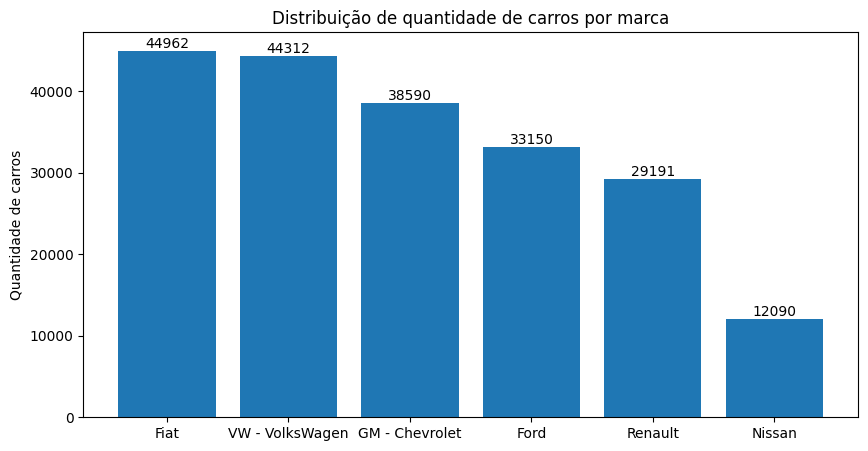

In [143]:
# Gráfico da distribuição por marca - plt é a biblioteca Matplotlib
plt.figure(figsize=(10,5))  # Aumentar o tamanho da figura na saída dos dados
grafico_1 = plt.bar(valores_por_marca.index, valores_por_marca.values)  # Variavel Marca X
plt.title('Distribuição de quantidade de carros por marca')  # plt.title para inserir título no gráfico
plt.ylabel('Quantidade de carros');  # plt.ylabel para inserir título no eixo Y
plt.bar_label(grafico_1, size=10);

###### 2b. Distribuição de quantidade de carros por tipo de câmbio do carro

In [144]:
valores_por_câmbio = dados['gear'].value_counts()  # Contagem do nº de carros por tipo de câmbio
print(valores_por_câmbio)

gear
manual       161883
automatic     40412
Name: count, dtype: int64


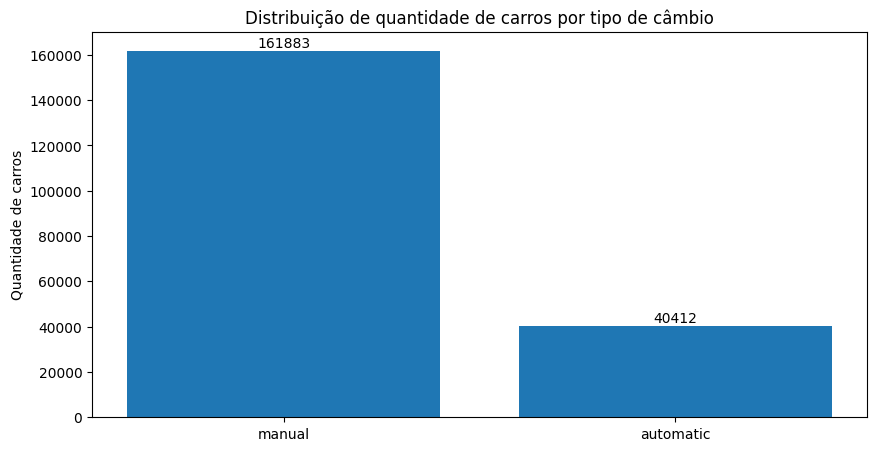

In [145]:
# Gráfico da distribuição por tipo de câmbio - plt é a biblioteca Matplotlib
plt.figure(figsize=(10,5))  # Aumentar o tamanho da figura na saída dos dados
grafico_2 = plt.bar(valores_por_câmbio.index, valores_por_câmbio.values)  # Variavel Marca X
plt.title('Distribuição de quantidade de carros por tipo de câmbio')  # plt.title para inserir título no gráfico
plt.ylabel('Quantidade de carros');  # plt.ylabel para inserir título no eixo Y
plt.bar_label(grafico_2, size=10);

###### 2c. Evolução média de preço dos carros ao longo dos meses de 2022

In [146]:
valores_2022 = dados[dados['year_of_reference'] == 2022]  # Obtendo apenas os dados de 2022
valores_2022.head(2)

,model,avg_price_brl,brand,fuel,gear,engine_size,year_model,fipe_code,month_of_reference,year_of_reference,authentication
96280,Corsa Wind 1.0 MPFI / EFI 2p,12330.0,GM - Chevrolet,Gasoline,manual,1.0,2002,004001-0,January,2022,gzw0hkct8cj4
96281,Corsa Wind 1.0 MPFI / EFI 2p,11408.0,GM - Chevrolet,Gasoline,manual,1.0,2001,004001-0,January,2022,gm2ws5yqjnfx


In [147]:
media_valores_2022 = valores_2022.groupby('month_of_reference')['avg_price_brl'].mean()  # Agrupando as linhas por mês e calculando a média para cada mês

In [148]:
meses_ordenados = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']  # Ordenando os meses para uma melhor visualização do gráfico

In [149]:
media_valores_2022 = media_valores_2022.reindex(meses_ordenados)  # Reordenando os meses para a visualização

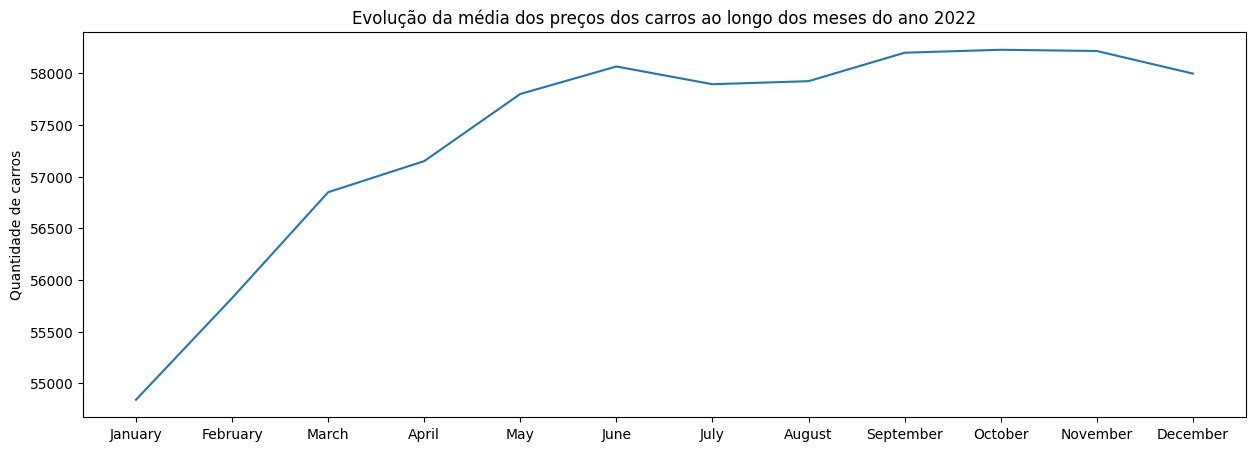

In [150]:
# Gráfico da evolução da média dos preços dos carros ao longo dos meses - plt é a biblioteca Matplotlib
plt.figure(figsize=(15,5))  # Aumentar o tamanho da figura na saída dos dados
grafico_3 = plt.plot(media_valores_2022.index, media_valores_2022.values)  # Variavel Mês X
plt.title('Evolução da média dos preços dos carros ao longo dos meses do ano 2022')  # plt.title para inserir título no gráfico
plt.ylabel('Quantidade de carros');  # plt.ylabel para inserir título no eixo Y

2d. Distribuição da média de preço dos carros por marca e tipo de câmbio.

In [151]:
media_valores = valores_2022.groupby(['brand', 'gear'])['avg_price_brl'].mean().reset_index()  # Resetando o index para transformar do formato Series -> Dataframe

<Axes: xlabel='brand', ylabel='avg_price_brl'>

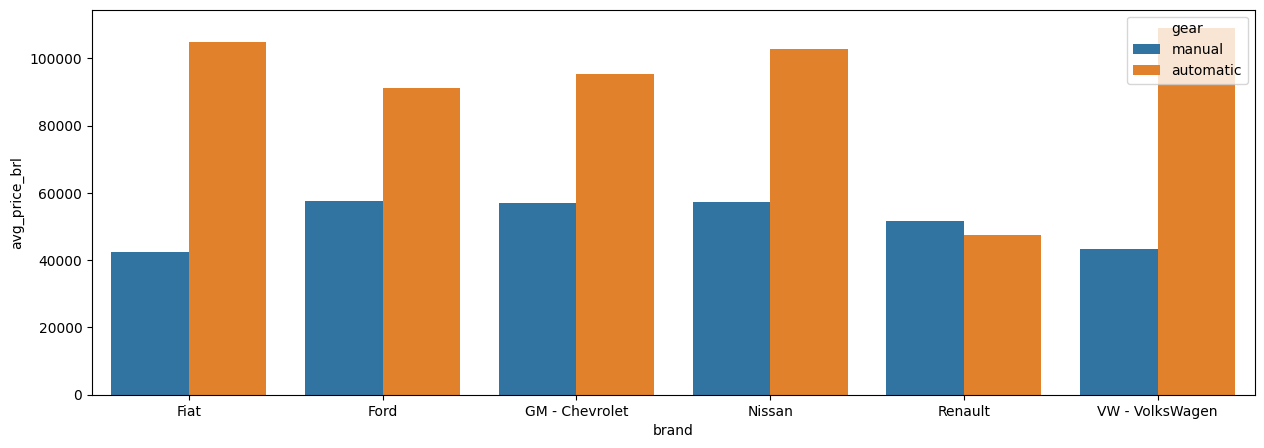

In [152]:
# Visualizando a média de preço por marca e tipo de câmbio
plt.figure(figsize=(15,5)) # Aumentar tamanho da imagem que será impressa na tela
sns.barplot(x='brand', y='avg_price_brl', hue='gear', data=media_valores, hue_order=['manual', 'automatic'])

2f. Distribuição da média de preço dos carros por marca e tipo de
combustível


In [153]:
media_valores_combustivel = valores_2022.groupby(['brand', 'fuel'])['avg_price_brl'].mean().reset_index()  # Resetando o index para transformar de Series -> Dataframe

<Axes: xlabel='brand', ylabel='avg_price_brl'>

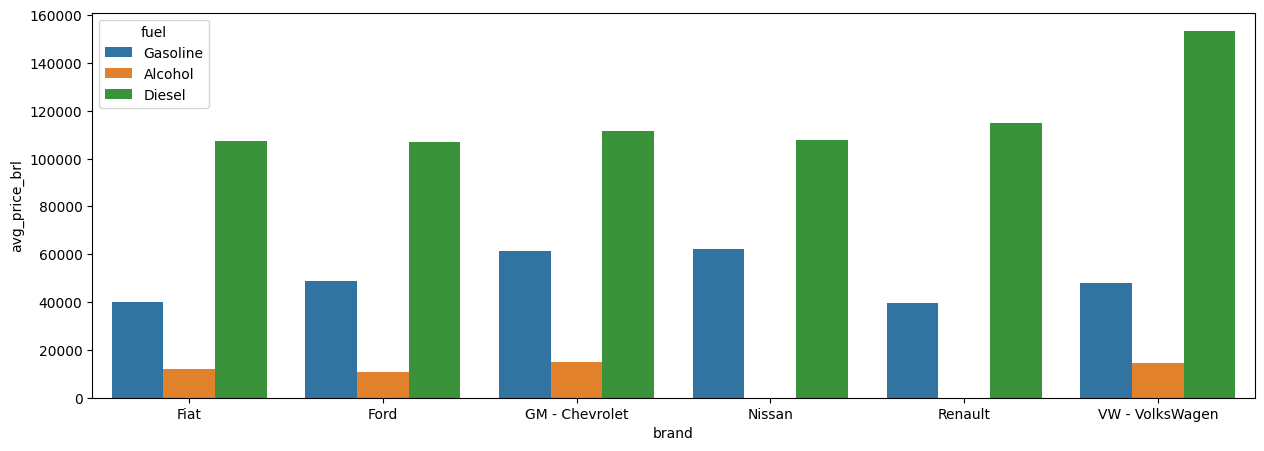

In [154]:
# Visualizando a média de preço por marca e tipo de combustível
plt.figure(figsize=(15,5)) # Aumentar tamanho da imagem que será impressa na tela
sns.barplot(x='brand', y='avg_price_brl', hue='fuel', data=media_valores_combustivel, hue_order=['Gasoline', 'Alcohol', 'Diesel'])

---
## Parte 5 - Machine Learning
Objetivo: Predizer o preço dos carros

### 1. Tratamento dos dados

In [155]:
dados_backup = dados.copy() # Criando uma cópia dos dados caso seja necessário pegar os dados originais e testar algumas transformações depois

In [156]:
# dados = dados_backup.copy() # Utilizar essa célula se for necessário recuperar os dados originais

###### 3a. Escolha de variáveis

In [157]:
categoricas_cols

['model',
 'brand',
 'fuel',
 'gear',
 'fipe_code',
 'month_of_reference',
 'authentication']

In [158]:
numericas_cols

['avg_price_brl', 'engine_size', 'year_model', 'year_of_reference']

In [159]:
print(f"Modelos de {(dados['year_model'].nunique())} anos diferentes.")

Modelos de 24 anos diferentes.


Pensando em variáveis que podem impactar o preço de venda de um carro, as seguintes variáveis foram escolhidas:
'engine_size' (n), 'year_model' (n), 'brand'(c), 'fuel'(c), 'gear'(c)

n- numérica | c- categórica

**Continuação 3a. Transformando variáveis categóricas
em numéricas**

Algoritmos de Machine Learning de Regressão não aceitam variáveis categóricas e, por isso, precisamos utilizar técnicas para converter as classes em números.

Optou-se pelo OneHotEncoder (no lugar do LabelEncoder) pois não há uma relação de ordem ou de hierarquia entre as variáveis escolhidas, dessa forma, ao invés de termos categorias como: 1, 2, 3 para representar o tipo de combustível, temos a criação de novas colunas binárias (ex.: fuel_Diesel - 0 ou 1). Assim, não enviesamos o modelo.

In [160]:
encoder = OneHotEncoder()

In [161]:
cat_cols_escolhidas = ['gear', 'brand', 'fuel']

In [162]:
dados_encoded = pd.get_dummies(dados, columns=cat_cols_escolhidas, drop_first=True)

In [163]:
dados_encoded.drop(columns=['model', 'fipe_code', 'authentication', 'month_of_reference', 'year_of_reference'], inplace=True)

In [164]:
dados_encoded.head(3)

,avg_price_brl,engine_size,year_model,gear_manual,brand_Ford,brand_GM - Chevrolet,brand_Nissan,brand_Renault,brand_VW - VolksWagen,fuel_Diesel,fuel_Gasoline
0,9162.0,1.0,2002,True,False,True,False,False,False,False,True
1,8832.0,1.0,2001,True,False,True,False,False,False,False,True
2,8388.0,1.0,2000,True,False,True,False,False,False,False,True


### 2. Divisão dos dados

Para a divisão de dados, optou-se por:

* Conjunto de Treinamento (X_train, y_train): Conjunto utilizado para treinar o modelo. Neste caso, 70% dos dados são selecionados para treinamento, conforme definido pela variável train_ratio.

* Conjunto de Teste (X_test, y_test): Conjunto utilizado para avaliar o desempenho do modelo em dados não vistos durante o treinamento. Neste caso, 30% dos dados são reservados para teste.

In [165]:
dados_encoded.columns

Index(['avg_price_brl', 'engine_size', 'year_model', 'gear_manual',
       'brand_Ford', 'brand_GM - Chevrolet', 'brand_Nissan', 'brand_Renault',
       'brand_VW - VolksWagen', 'fuel_Diesel', 'fuel_Gasoline'],
      dtype='object')

In [166]:
X = dados_encoded.drop(columns=['avg_price_brl'])  # Selecionando todas as variaveis exceto a variável target
y = dados_encoded['avg_price_brl']  # Selecionando apenas a variável alvo

3b. Divisão entre treino e teste

In [167]:
# Divisão: 30% dos dados são de teste e 70% de treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [168]:
X_train.head(2)

,engine_size,year_model,gear_manual,brand_Ford,brand_GM - Chevrolet,brand_Nissan,brand_Renault,brand_VW - VolksWagen,fuel_Diesel,fuel_Gasoline
100552,1.6,2015,True,True,False,False,False,False,False,True
200898,1.0,2003,True,False,False,False,False,True,False,True


In [169]:
y_train.head(2)

,avg_price_brl
100552,56990.0
200898,11857.0


### 3. Treinamento do modelo
Os seguintes algoritmos foram testados: XGBoost e RandomForest

#### 3c. Aqui vamos treinar 2 modelos, sendo a variável target o 'avg_price_brl' e as variáveis de entrada: 'engine_size', 'year_model', 'gear', 'brand', 'fuel'.
- Random Forest - combina a saída de múltiplas árvores de decisão para chegar a um único resultado
- XGBoost - significa “eXtreme Gradient Boosting”. Essa técnica é baseada no conceito de boosting, que consiste em combinar vários modelos fracos para criar um modelo forte

Random Forest

In [170]:
# Algoritmo Random Forest, sem especificar nenhum parâmetro (número de árvores, número de ramificações, etc)
model_rf = RandomForestRegressor()

In [171]:
# Ajuste do modelo, de acordo com as variáveis de treinamento
model_rf.fit(X_train, y_train)

RandomForestRegressor()

3d. Gravando valores preditos

In [172]:
# Predição dos valores de salário com base nos dados de teste
valores_preditos_rf = model_rf.predict(X_test)

In [173]:
valores_preditos_rf

array([ 42273.26148537,  13454.69028339,  14530.41872087, ...,
       117357.56417604, 129559.19554435,  83181.37898537])

3e. Realizando análise de importância

In [174]:
model_rf.feature_importances_
feature_importances = pd.DataFrame(model_rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending = False)
feature_importances

,importance
engine_size,0.436255
year_model,0.401125
fuel_Diesel,0.081240
gear_manual,0.034583
brand_VW - VolksWagen,0.014353
brand_Nissan,0.014254
fuel_Gasoline,0.009639
brand_Ford,0.002961
brand_GM - Chevrolet,0.002877
brand_Renault,0.002714


XGBoost

In [175]:
model_xgboost = XGBRegressor()

In [176]:
model_xgboost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

3d. Gravando valores preditos

In [177]:
valores_preditos_xgboost = model_xgboost.predict(X_test)
valores_preditos_xgboost

array([ 42201.207,  13415.068,  14663.888, ..., 117738.54 , 130857.766,
        83928.625], dtype=float32)

3e. Realizando análise de importância

In [178]:
model_xgboost.feature_importances_
feature_importances = pd.DataFrame(model_xgboost.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending = False)
feature_importances

,importance
fuel_Diesel,0.426133
engine_size,0.247360
year_model,0.170271
brand_VW - VolksWagen,0.055077
gear_manual,0.041812
brand_Nissan,0.023557
brand_Renault,0.021131
brand_GM - Chevrolet,0.007756
brand_Ford,0.005958
fuel_Gasoline,0.000946


### 4. Avaliação
Quão acurado é o modelo para estabelecer as predições de preço?

Existem diversas métricas para avaliar o erro da predição do nosso modelo. Hoje iremos ver as seguintes:
- MSE (Mean Squared Error) calcula o erro quadrático médio das predições do nosso modelo. Quanto maior o MSE, pior é o modelo.
- MAE (Mean Absolute Error) calcula a média da diferença absoluta entre o valor predito e o valor real. Nesse caso, os erros são penalizados linearmente, ou seja, todos terão o mesmo peso na média.
- R² é uma métrica que varia entre 0 e 1 e é uma razão que indica o quão bom o nosso modelo. Quanto maior seu valor, melhor é o modelo.

RandomForest - Avaliação

In [179]:
print(f"MSE: {mean_squared_error(y_test, valores_preditos_rf)}")
print(f"MAE: {mean_absolute_error(y_test, valores_preditos_rf)}")
print(f"R2: {r2_score(y_test, valores_preditos_rf)}")

MSE: 135699134.93185735
MAE: 6516.190893525987
R2: 0.9494215351359274


XGBoost - Avaliação

In [180]:
print(f"MSE: {mean_squared_error(y_test, valores_preditos_xgboost)}")
print(f"MAE: {mean_absolute_error(y_test, valores_preditos_xgboost)}")
print(f"R2: {r2_score(y_test, valores_preditos_xgboost)}")

MSE: 136469895.6356106
MAE: 6558.66522227759
R2: 0.9491342533253767


3g. Escolha do melhor modelo: Ambos os modelos tiveram bons desempenhos com diferenças minímas. Com isso, o que teve levemente um melhor desempenho, foi o RandomForest, sendo o modelo escolhido.